In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
url = pd.read_csv('Data/mendely_url.csv')
url

,rec_id,url,website,result,created_date
0,1,http://intego3.info/EXEL/index.php,1613573972338075.html,1,2021-02-17 20:29:32
1,2,https://www.mathopenref.com/segment.html,1635698138155948.html,0,2021-10-31 16:35:38
2,3,https://www.computerhope.com/issues/ch000254.htm,1635699228889266.html,0,2021-10-31 16:53:48
3,4,https://www.investopedia.com/terms/n/next-elev...,1635750062162701.html,0,2021-11-01 12:31:02
4,5,https://jobs.emss.org.uk/lcc.aspx,161356510250721.html,0,2021-02-17 18:01:42
...,...,...,...,...,...
79696,79996,https://bestjobmanage.com/adminservicedesk/True/,1622125898152592.html,1,2021-05-27 14:31:38
79697,79997,http://vieuxshack.com/download/adobe/b51f18074...,160822961118687.html,1,2020-12-17 23:56:51
79698,79998,https://www.tumblr.com/search/gas%20mask%20tattoo,163570726902772.html,0,2021-10-31 19:07:49
79699,79999,https://www.magnetic-shield.com/pdf/wc_4.pdf,1635701992217159.html,0,2021-10-31 17:39:52


In [3]:
# created_date를 datetime 형식으로 변환
url['created_date'] = pd.to_datetime(url['created_date'])

# 연도, 월, 일, 시간, 분, 초로 분리
url['created_year'] = url['created_date'].dt.year
url['created_month'] = url['created_date'].dt.month
url['created_day'] = url['created_date'].dt.day
url['created_hour'] = url['created_date'].dt.hour
#url['created_minute'] = url['created_date'].dt.minute
#url['created_second'] = url['created_date'].dt.second

# created_date 컬럼 제거
url.drop(columns=['created_date'], inplace=True)

# website 컬럼 제거
url.drop(columns=['website'], inplace=True)

# rec_id 컬럼 제거
url.drop(columns=['rec_id'], inplace=True)

In [4]:
url

,url,result,created_year,created_month,created_day,created_hour
0,http://intego3.info/EXEL/index.php,1,2021,2,17,20
1,https://www.mathopenref.com/segment.html,0,2021,10,31,16
2,https://www.computerhope.com/issues/ch000254.htm,0,2021,10,31,16
3,https://www.investopedia.com/terms/n/next-elev...,0,2021,11,1,12
4,https://jobs.emss.org.uk/lcc.aspx,0,2021,2,17,18
...,...,...,...,...,...,...
79696,https://bestjobmanage.com/adminservicedesk/True/,1,2021,5,27,14
79697,http://vieuxshack.com/download/adobe/b51f18074...,1,2020,12,17,23
79698,https://www.tumblr.com/search/gas%20mask%20tattoo,0,2021,10,31,19
79699,https://www.magnetic-shield.com/pdf/wc_4.pdf,0,2021,10,31,17


In [5]:
# result 컬럼에서 1과 0의 개수 세기
result_counts = url['result'].value_counts()
result_counts

result
0    49737
1    29964
Name: count, dtype: int64

In [6]:
49737 - 29964

19773

In [7]:
#랜덤언더샘플링
rows_to_drop = url[url['result'] == 0].sample(n=19773, random_state=42).index
url = url.drop(index=rows_to_drop).reset_index(drop=True)

In [8]:
url.to_csv('Data/undersampled_url.csv', index=False, encoding='utf-8-sig')

In [9]:
url = pd.read_csv('Data/undersampled_url.csv')

In [10]:
# f1: 전체 URL 길이
url['url_length'] = url['url'].apply(len)

# f2: 호스트 이름 길이
url['hostname_length'] = url['url'].apply(
    lambda x: len(re.search(r'://(.*?)(/|$)', x).group(1)) if re.search(r'://(.*?)(/|$)', x) else len(x)
)

# f3: IP 주소 포함 여부
url['has_ip'] = url['url'].apply(lambda x: 1 if re.match(r'^http[s]?://(\d+\.\d+\.\d+\.\d+)', x) else 0)

# f4-f20: 특수문자 개수
special_chars = ['.', '-', '@', '?', '&', '=', '_', '~', '%', '/', '*', ':', ',', ';', '$', '+', '#', '(', ')', '[', ']']
url['special_char_sum'] = url['url'].apply(lambda x: sum(x.count(char) for char in special_chars))

# f21-f24: 공통 키워드 ("www", ".com", "http", "//") 개수
common_terms = ['www', '.com', 'http', '//']
url['common_term_sum'] = url['url'].apply(lambda x: sum(x.count(term) for term in common_terms))

# f25: HTTPS 사용 여부-> f21-f24랑 비슷
#url['is_https'] = url['url'].apply(lambda x: 1 if x.startswith('https://') else 0)

# f26-f27: URL 내 숫자 비율
url['digit_ratio'] = url['url'].apply(lambda x: sum(c.isdigit() for c in x) / len(x))

# Punycode 사용 여부
#url['has_punycode'] = url['url'].apply(lambda x: 1 if re.search(r'xn--', x.lower()) else 0)

# f29: 포트 번호 포함 여부
url['has_port'] = url['url'].apply(lambda x: 1 if re.search(r':\d+', x) else 0)

# f30-f31: 비정상 TLD 위치 (path나 서브도메인에 TLD 존재 여부)
tld_patterns = [r'\.com/', r'\.net/', r'\.org/', r'\.info/', r'\.xyz/', r'\.top/', r'\.site/', r'\.online/']
# TLD가 비정상적인 위치에 있는지 판단
def check_abnormal_tld(url):
    # 경로 내 TLD 포함 여부
    if any(re.search(pattern, url) for pattern in tld_patterns):
        # 서브도메인에 포함된 경우 제외
        if re.search(r'https?://[^/]*\.(com|net|org|info|xyz|top|site|online)', url):
            return 0  # 정상적인 경우
        return 1  # 비정상적인 경우
    return 0  # TLD 없음

url['abnormal_tld_in_path'] = url['url'].apply(check_abnormal_tld)

# f32: 비정상 서브도메인 (의심 서브도메인 패턴 확인)
url['abnormal_subdomain'] = url['url'].apply(lambda x: 1 if re.search(r'v[\w]*\d', x) else 0)

# f33: 서브도메인 개수
url['num_subdomains'] = url['url'].apply(lambda x: len(re.findall(r'\.', re.search(r'://(.*?)/', x).group(1))) - 1 if re.search(r'://(.*?)/', x) else 0)

# f34: 접두사-접미사 포함 여부 (하이픈의 존재 여부)
url['has_prefix_suffix'] = url['url'].apply(
    lambda x: 1 if re.search(r'://(.*?)/', x) and '-' in re.search(r'://(.*?)/', x).group(1) else 0
)

# f36: 단축 서비스 여부
shortening_services_pattern = r'(bit\.ly|tinyurl\.com|goo\.gl|short\.ly|t\.co|is\.gd|v\.gd|buff\.ly|adf\.ly|ow\.ly|lnkd\.in|qr\.ae)'
url['is_shortened'] = url['url'].apply(lambda x: 1 if re.search(shortening_services_pattern, x) else 0)

# f37: 의심 확장자 포함 여부 (.txt, .exe, .js)
suspicious_texts = [
    '.exe', '.bat', '.cmd', '.msi', '.apk', '.sh',  # 실행 파일
    '.js', '.vbs', '.cgi', '.php', '.asp', '.aspx', # 스크립트 파일
    '.zip', '.rar', '.7z',                         # 압축 파일
    '.doc', '.docx', '.xls', '.xlsx', '.pdf'       # 문서 파일
]

url['has_suspicious_text'] = url['url'].apply(lambda x: 1 if any(x.endswith(ext) for ext in suspicious_texts) else 0)

# f38-f39: 리다이렉션 수
#import requests
#def count_redirects(url):
#    try:
#        response = requests.get(url, allow_redirects=True)
#        return len(response.history)
#    except:
#        return 0
#url['num_redirects'] = url['url'].apply(count_redirects)


# f40-f50+ f51 : 피싱 단어
phish_terms = [
    'login', 'secure', 'bank', 'verify', 'free', 'account', 'validate', 'authenticate',
    'password', 'signin', 'signup', 'access', 'safety', 'protection', 'banking', 
    'credit', 'debit', 'transaction', 'urgent', 'important', 'update', 'confirm', 
    'click', 'alert', 'bonus', 'win', 'prize', 'reward', 'offer', 'gift', 'limited', 
    'expires', 'deadline'
]

phishing_hints = [
    'free', 'click', 'update', 'offer', 'validate', 'urgent', 'secure', 'confirm', 
    'reward', 'gift', 'now', 'limited', 'deadline', 'signin', 'signup', 'bonus', 
    'prize', 'alert', 'important'
]

combined_terms = set(phish_terms + phishing_hints)
url['phish_word'] = url['url'].apply(lambda x: sum(term in x.lower() for term in combined_terms))

# f52-f54: 브랜드 이름괴 유사도 측정
from rapidfuzz import fuzz

brands = [
    'google', 'paypal', 'amazon', 'facebook', 'microsoft', 'apple', 'netflix', 
    'linkedin', 'twitter', 'instagram', 'youtube', 'whatsapp', 'visa', 'mastercard', 
    'chase', 'wellsfargo', 'citibank', 'stripe', 'square', 'ebay', 'alibaba', 
    'shopify', 'walmart', 'target', 'spotify', 'zoom', 'uber', 'airbnb'
]

url['brand_in_subdomain'] = url['url'].apply(
    lambda x: 1 if any(brand in x.lower() for brand in brands) or 
              any(fuzz.partial_ratio(brand, x.lower()) > 80 for brand in brands) else 0
)

# 결과 출력
url

,url,result,created_year,created_month,created_day,created_hour,url_length,hostname_length,has_ip,special_char_sum,...,digit_ratio,has_port,abnormal_tld_in_path,abnormal_subdomain,num_subdomains,has_prefix_suffix,is_shortened,has_suspicious_text,phish_word,brand_in_subdomain
0,http://intego3.info/EXEL/index.php,1,2021,2,17,20,34,12,0,7,...,0.029412,0,0,0,0,0,0,1,0,0
1,https://www.investopedia.com/terms/n/next-elev...,0,2021,11,1,12,52,20,0,10,...,0.000000,0,0,0,1,0,0,1,0,0
2,https://jobs.emss.org.uk/lcc.aspx,0,2021,2,17,18,33,16,0,8,...,0.000000,0,0,0,2,0,0,1,0,0
3,https://paribas-biznesplanet-logowanie.com,1,2020,12,21,23,42,34,0,6,...,0.000000,0,0,0,0,0,0,0,0,0
4,https://best-mac-tips.com/2014/08/14/changing-...,0,2021,10,31,18,82,17,0,18,...,0.097561,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59923,https://bestjobmanage.com/adminservicedesk/True/,1,2021,5,27,14,48,17,0,7,...,0.000000,0,0,0,0,0,0,0,0,0
59924,http://vieuxshack.com/download/adobe/b51f18074...,1,2020,12,17,23,245,14,0,18,...,0.334694,0,0,0,0,0,0,0,1,0
59925,https://www.tumblr.com/search/gas%20mask%20tattoo,0,2021,10,31,19,49,14,0,9,...,0.081633,0,0,0,1,0,0,0,0,0
59926,https://www.magnetic-shield.com/pdf/wc_4.pdf,0,2021,10,31,17,44,23,0,10,...,0.022727,0,0,0,1,1,0,1,0,0


In [11]:
url.to_csv('Data/preprocessed_final_url.csv', index=False, encoding='utf-8-sig')

In [12]:
url = pd.read_csv('Data/preprocessed_final_url.csv')

In [13]:
# 컬럼 # 컬럼 이름 추출
column_names = url.columns.tolist()
column_names

['url',
 'result',
 'created_year',
 'created_month',
 'created_day',
 'created_hour',
 'url_length',
 'hostname_length',
 'has_ip',
 'special_char_sum',
 'common_term_sum',
 'digit_ratio',
 'has_port',
 'abnormal_tld_in_path',
 'abnormal_subdomain',
 'num_subdomains',
 'has_prefix_suffix',
 'is_shortened',
 'has_suspicious_text',
 'phish_word',
 'brand_in_subdomain']

In [14]:
# 모든 컬럼의 value_counts() 결과를 저장할 딕셔너리
value_counts_dict = {}

# 각 컬럼에 대해 value_counts() 계산
for col in url.columns:
    value_counts_dict[col] = url[col].value_counts()

# 결과 출력 (각 변수별 value_counts)
for col, counts in value_counts_dict.items():
    print(f"Value counts for column: {col}")
    print(counts)
    print()

Value counts for column: url
url
https://www.ebay.com/n/all-categories                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     4
https://ncbagroup.com/                                                                                                                                                                                                                                     

In [15]:
# result가 1인 데이터와 0인 데이터로 나누기
result_1 = url[url['result'] == 1]
result_0 = url[url['result'] == 0]

# 숫자형 컬럼만 선택 (mean 계산이 가능한 컬럼)
numeric_columns = url.select_dtypes(include=['number']).columns

# 각 컬럼의 평균값 계산
mean_result_1 = result_1[numeric_columns].mean()
mean_result_0 = result_0[numeric_columns].mean()

# 평균값 데이터프레임 생성
mean_values = pd.DataFrame({
    'result_1_mean': mean_result_1,
    'result_0_mean': mean_result_0
})

# 결과 출력
print(mean_values)

                      result_1_mean  result_0_mean
result                     1.000000       0.000000
created_year            2020.718195    2020.857396
created_month              6.552663       8.032406
created_day               17.336871      22.972734
created_hour              16.772293      14.703277
url_length                72.936457      58.251001
hostname_length           23.521960      17.851689
has_ip                     0.015519       0.000100
special_char_sum          10.757042      10.256975
common_term_sum            2.859832       3.332532
digit_ratio                0.081944       0.028315
has_port                   0.002803       0.005206
abnormal_tld_in_path       0.004405       0.000167
abnormal_subdomain         0.060740       0.010012
num_subdomains             0.810940       0.868209
has_prefix_suffix          0.311274       0.059972
is_shortened               0.075657       0.070952
has_suspicious_text        0.152650       0.037912
phish_word                 0.45

In [16]:
features = [
    'url_length', 'hostname_length', 'has_ip', 'special_char_sum', 
    'common_term_sum', 'digit_ratio', 'has_port', 
    'abnormal_tld_in_path', 'abnormal_subdomain', 'num_subdomains', 
    'has_prefix_suffix', 'is_shortened', 'has_suspicious_text', 
    'phish_word', 'brand_in_subdomain'
]

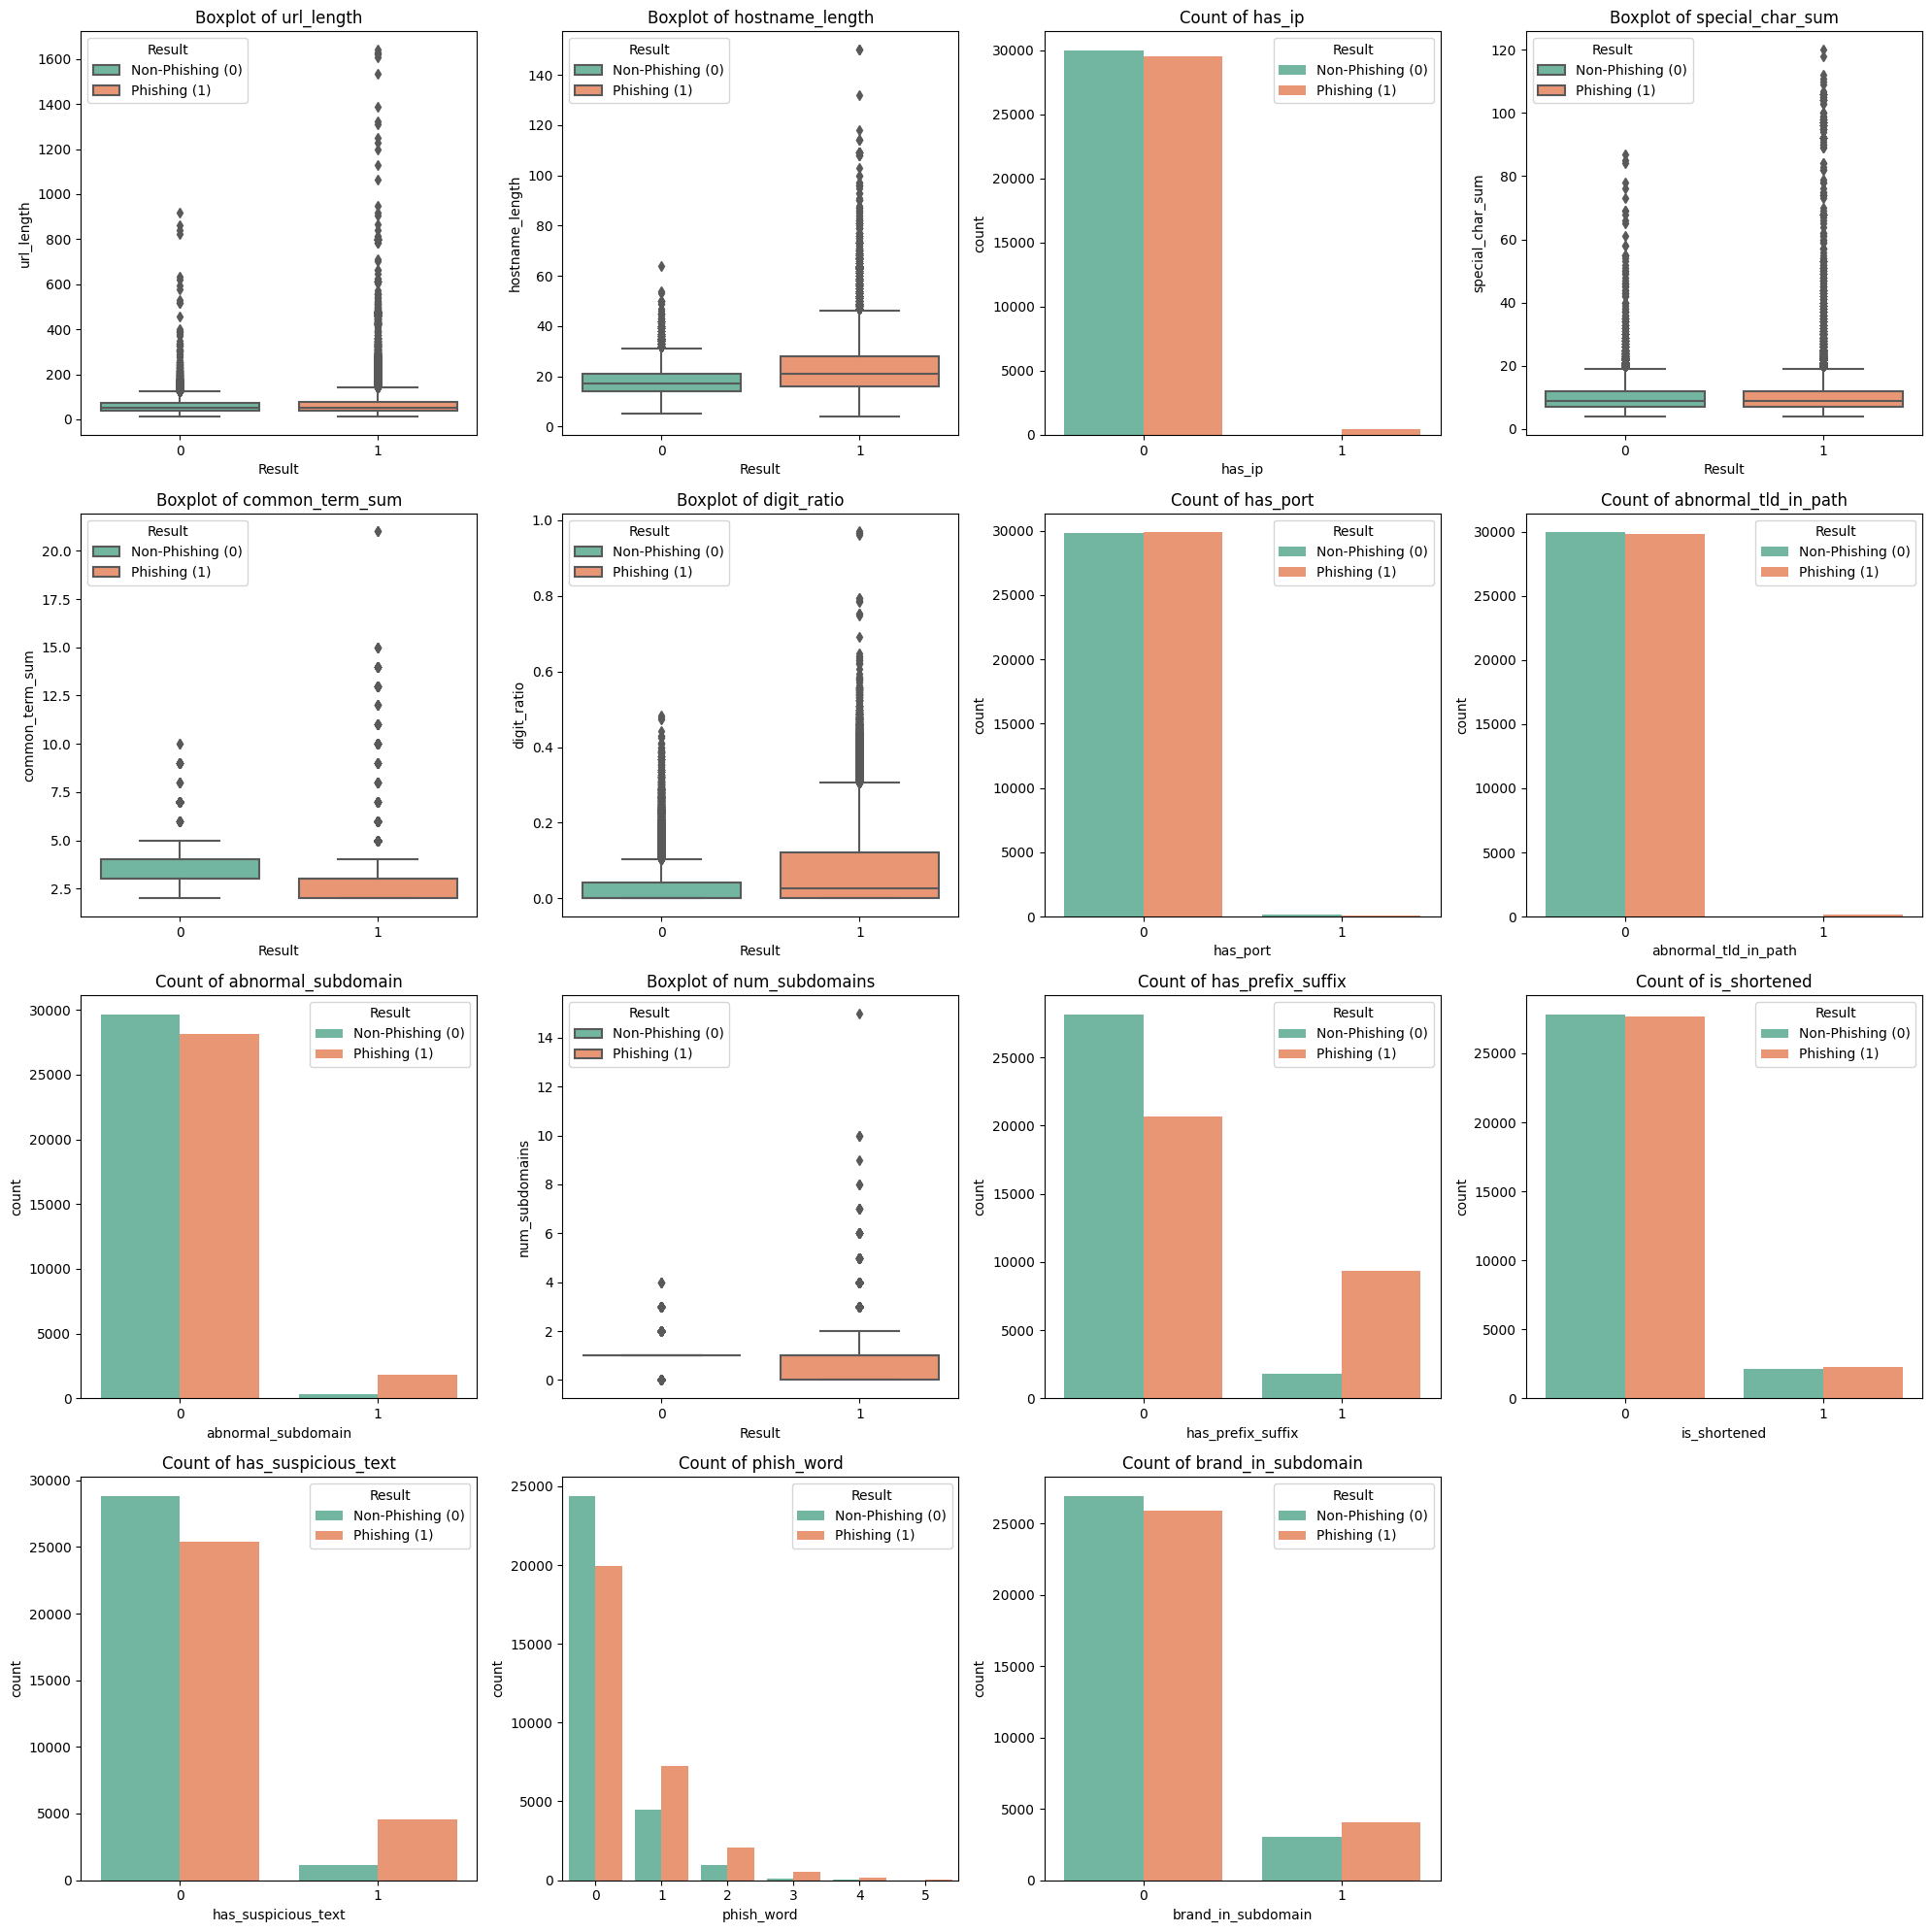

In [17]:
# 시각화를 위한 그리드 생성
num_features = len(features)
cols = 4
rows = (num_features + cols - 1) // cols  # 필요한 행 계산
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

# 각 변수 특성에 따른 시각화
for i, feature in enumerate(features):
    if url[feature].nunique() <= 10:  # 고유값이 적은 경우 countplot 사용
        sns.countplot(
            data=url, 
            x=feature, 
            hue="result", 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Count of {feature}')
    elif url[feature].dtype == 'float64' or url[feature].dtype == 'int64':  # 수치형 변수는 boxplot 사용
        sns.boxplot(
            data=url, 
            x="result", 
            y=feature, 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Boxplot of {feature}')
        axes[i].set_xlabel('Result')
        axes[i].set_ylabel(feature)
    else:  # 기본적으로 histogram과 KDE 사용
        sns.histplot(
            data=url, 
            x=feature, 
            hue="result", 
            multiple="dodge", 
            kde=True, 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {feature}')
    
    axes[i].legend(title='Result', labels=['Non-Phishing (0)', 'Phishing (1)'])

# 사용되지 않은 서브플롯 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()

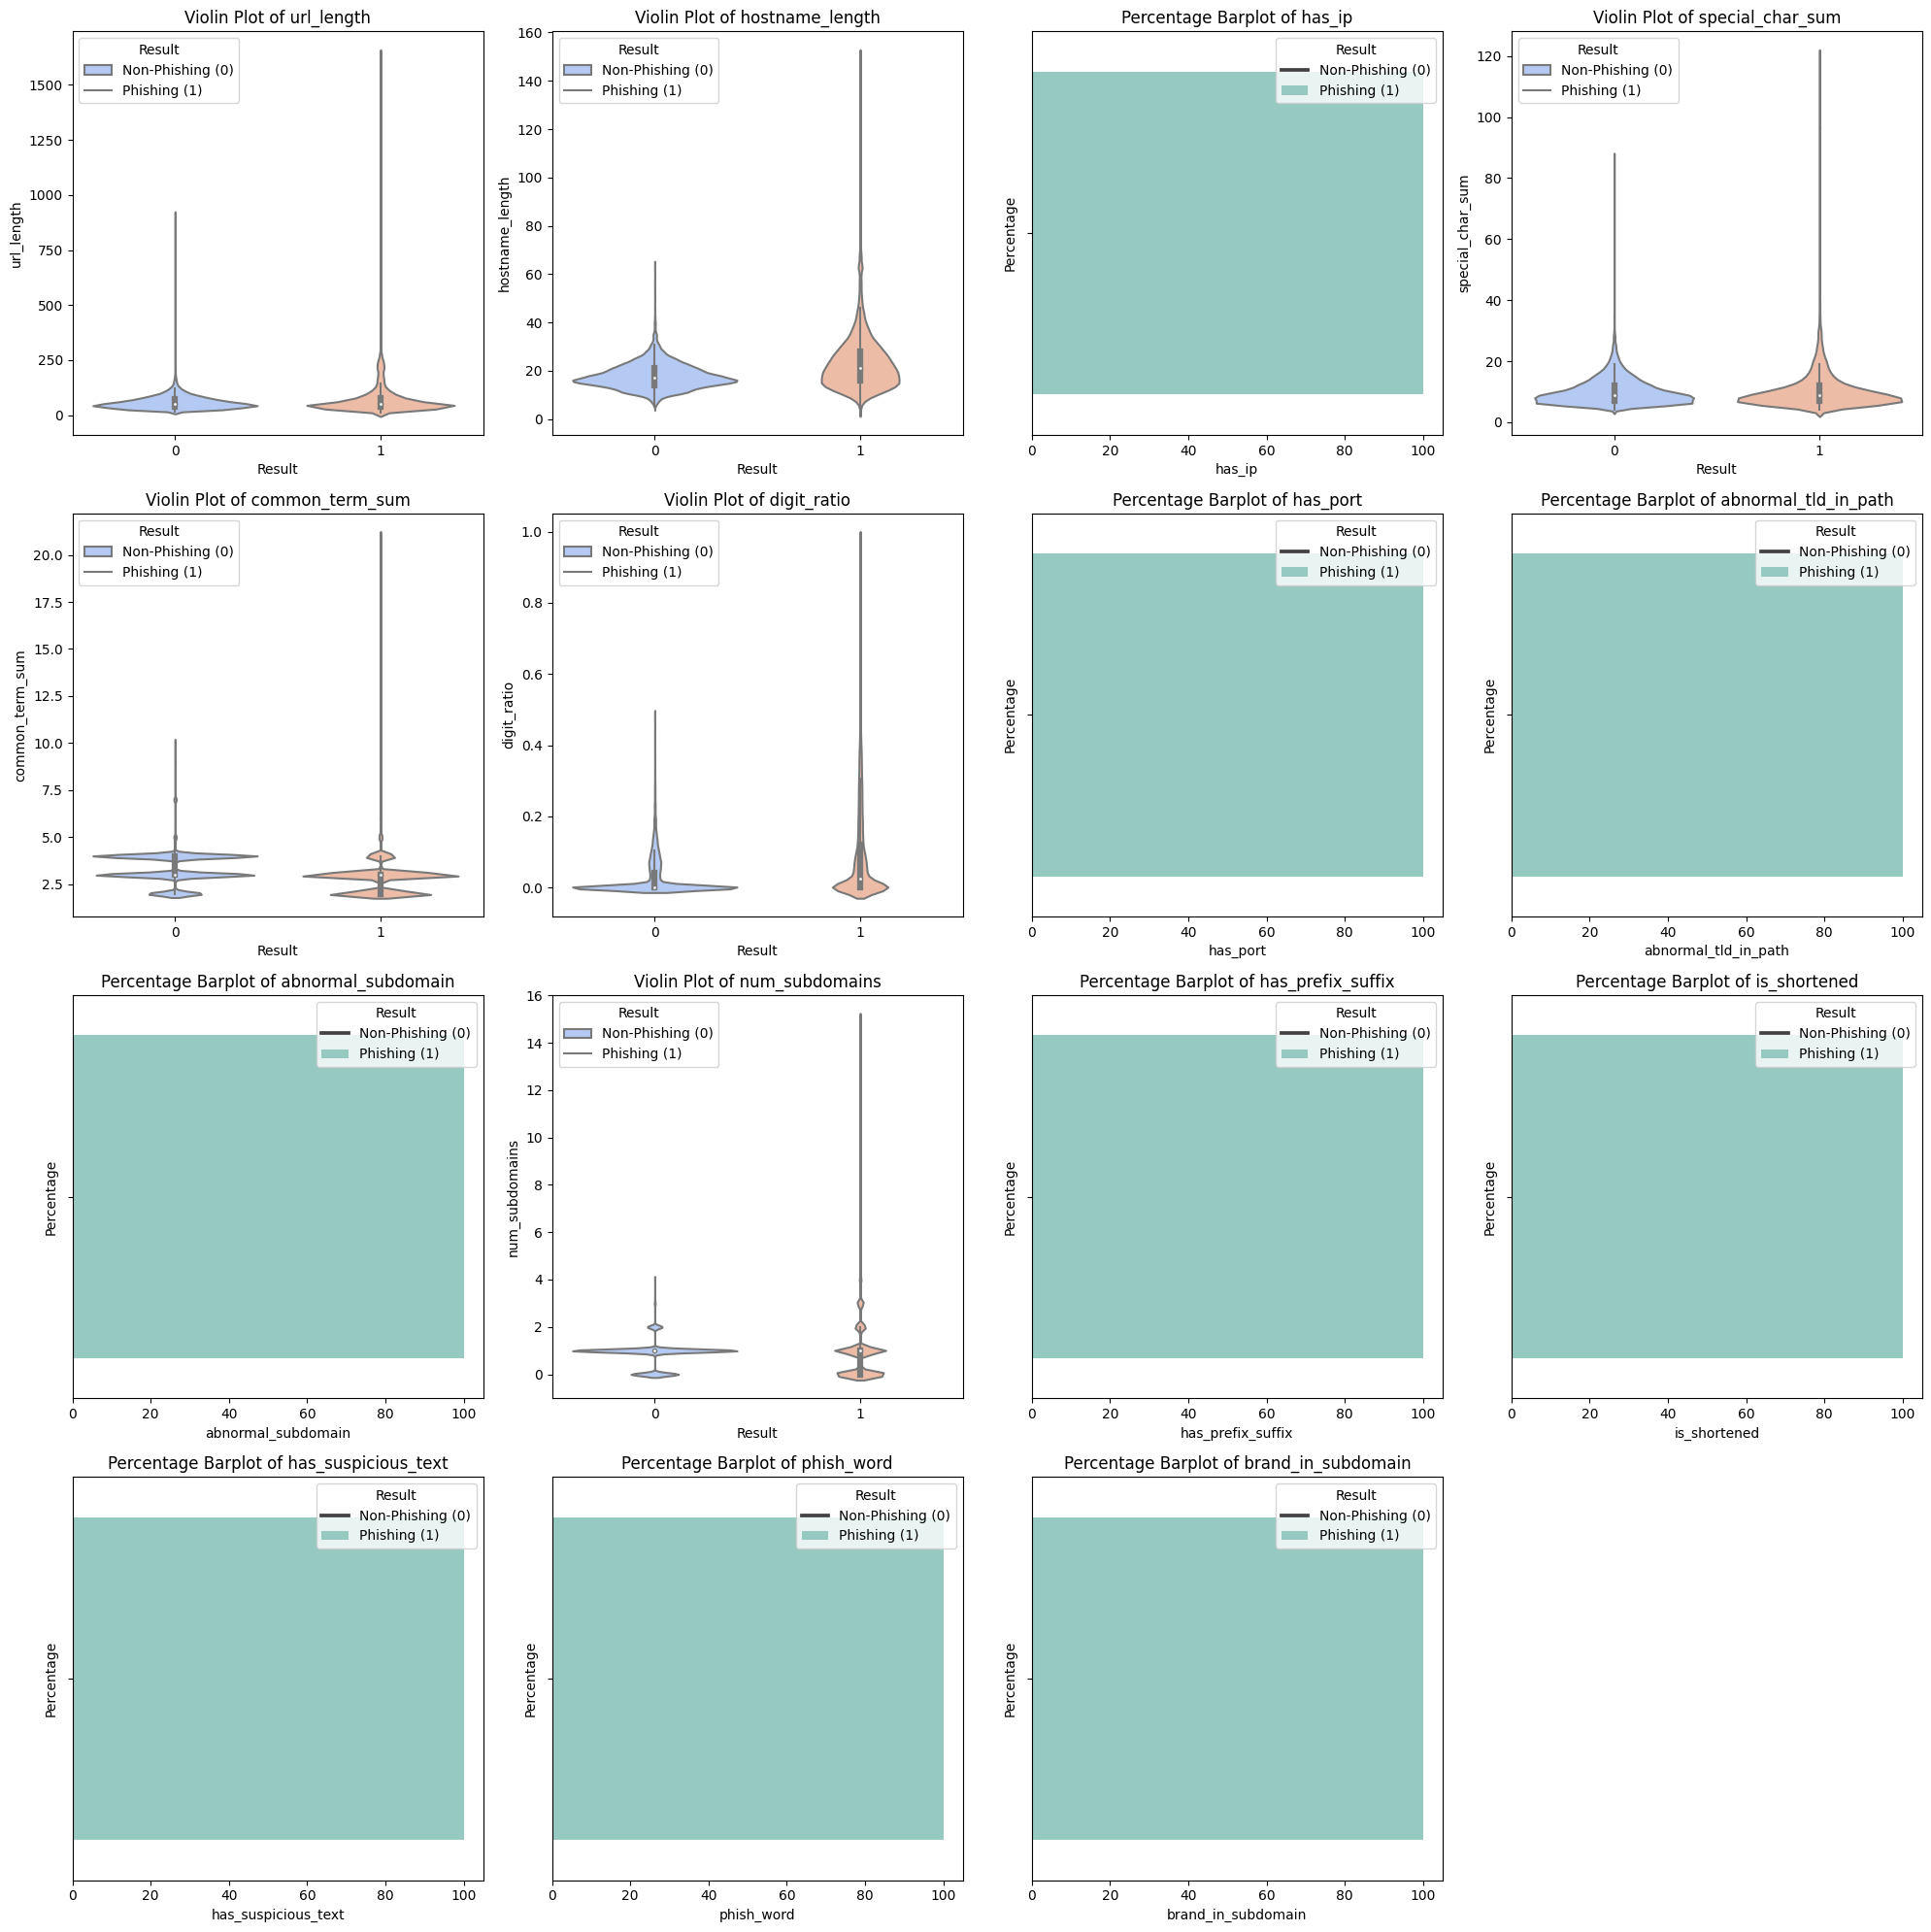

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화를 위한 그리드 생성
num_features = len(features)
cols = 4
rows = (num_features + cols - 1) // cols  # 필요한 행 계산
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

# 각 변수 특성에 따른 시각화
for i, feature in enumerate(features):
    unique_vals = url[feature].nunique()
    dtype = url[feature].dtype
    
    # 범주형 변수: 고유값이 적은 경우 Barplot 사용
    if unique_vals <= 10 and dtype in ['int64', 'object']:
        sns.barplot(
            data=url, 
            x=feature, 
            hue="result", 
            palette="Set3", 
            ax=axes[i],
            estimator=lambda x: len(x) / len(url) * 100  # 퍼센티지로 표시
        )
        axes[i].set_title(f'Percentage Barplot of {feature}')
        axes[i].set_ylabel('Percentage')
    
    # 연속형 변수: 값의 범위가 넓은 경우 Violin Plot 사용
    elif dtype in ['float64', 'int64'] and unique_vals > 10:
        sns.violinplot(
            data=url, 
            x="result", 
            y=feature, 
            palette="coolwarm", 
            ax=axes[i]
        )
        axes[i].set_title(f'Violin Plot of {feature}')
        axes[i].set_xlabel('Result')
        axes[i].set_ylabel(feature)
    
    # 이진 변수: 고유값이 2개인 경우 Barplot 사용
    elif unique_vals == 2:
        sns.barplot(
            data=url, 
            x=feature, 
            hue="result", 
            palette="Set2", 
            ax=axes[i],
            estimator=lambda x: len(x) / len(url) * 100  # 퍼센티지로 표시
        )
        axes[i].set_title(f'Percentage Barplot of {feature}')
        axes[i].set_ylabel('Percentage')
    
    # 그 외: Histogram과 KDE 사용
    else:
        sns.histplot(
            data=url, 
            x=feature, 
            hue="result", 
            multiple="stack", 
            kde=True, 
            palette="husl", 
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')
    
    axes[i].legend(title='Result', labels=['Non-Phishing (0)', 'Phishing (1)'])

# 사용되지 않은 서브플롯 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()


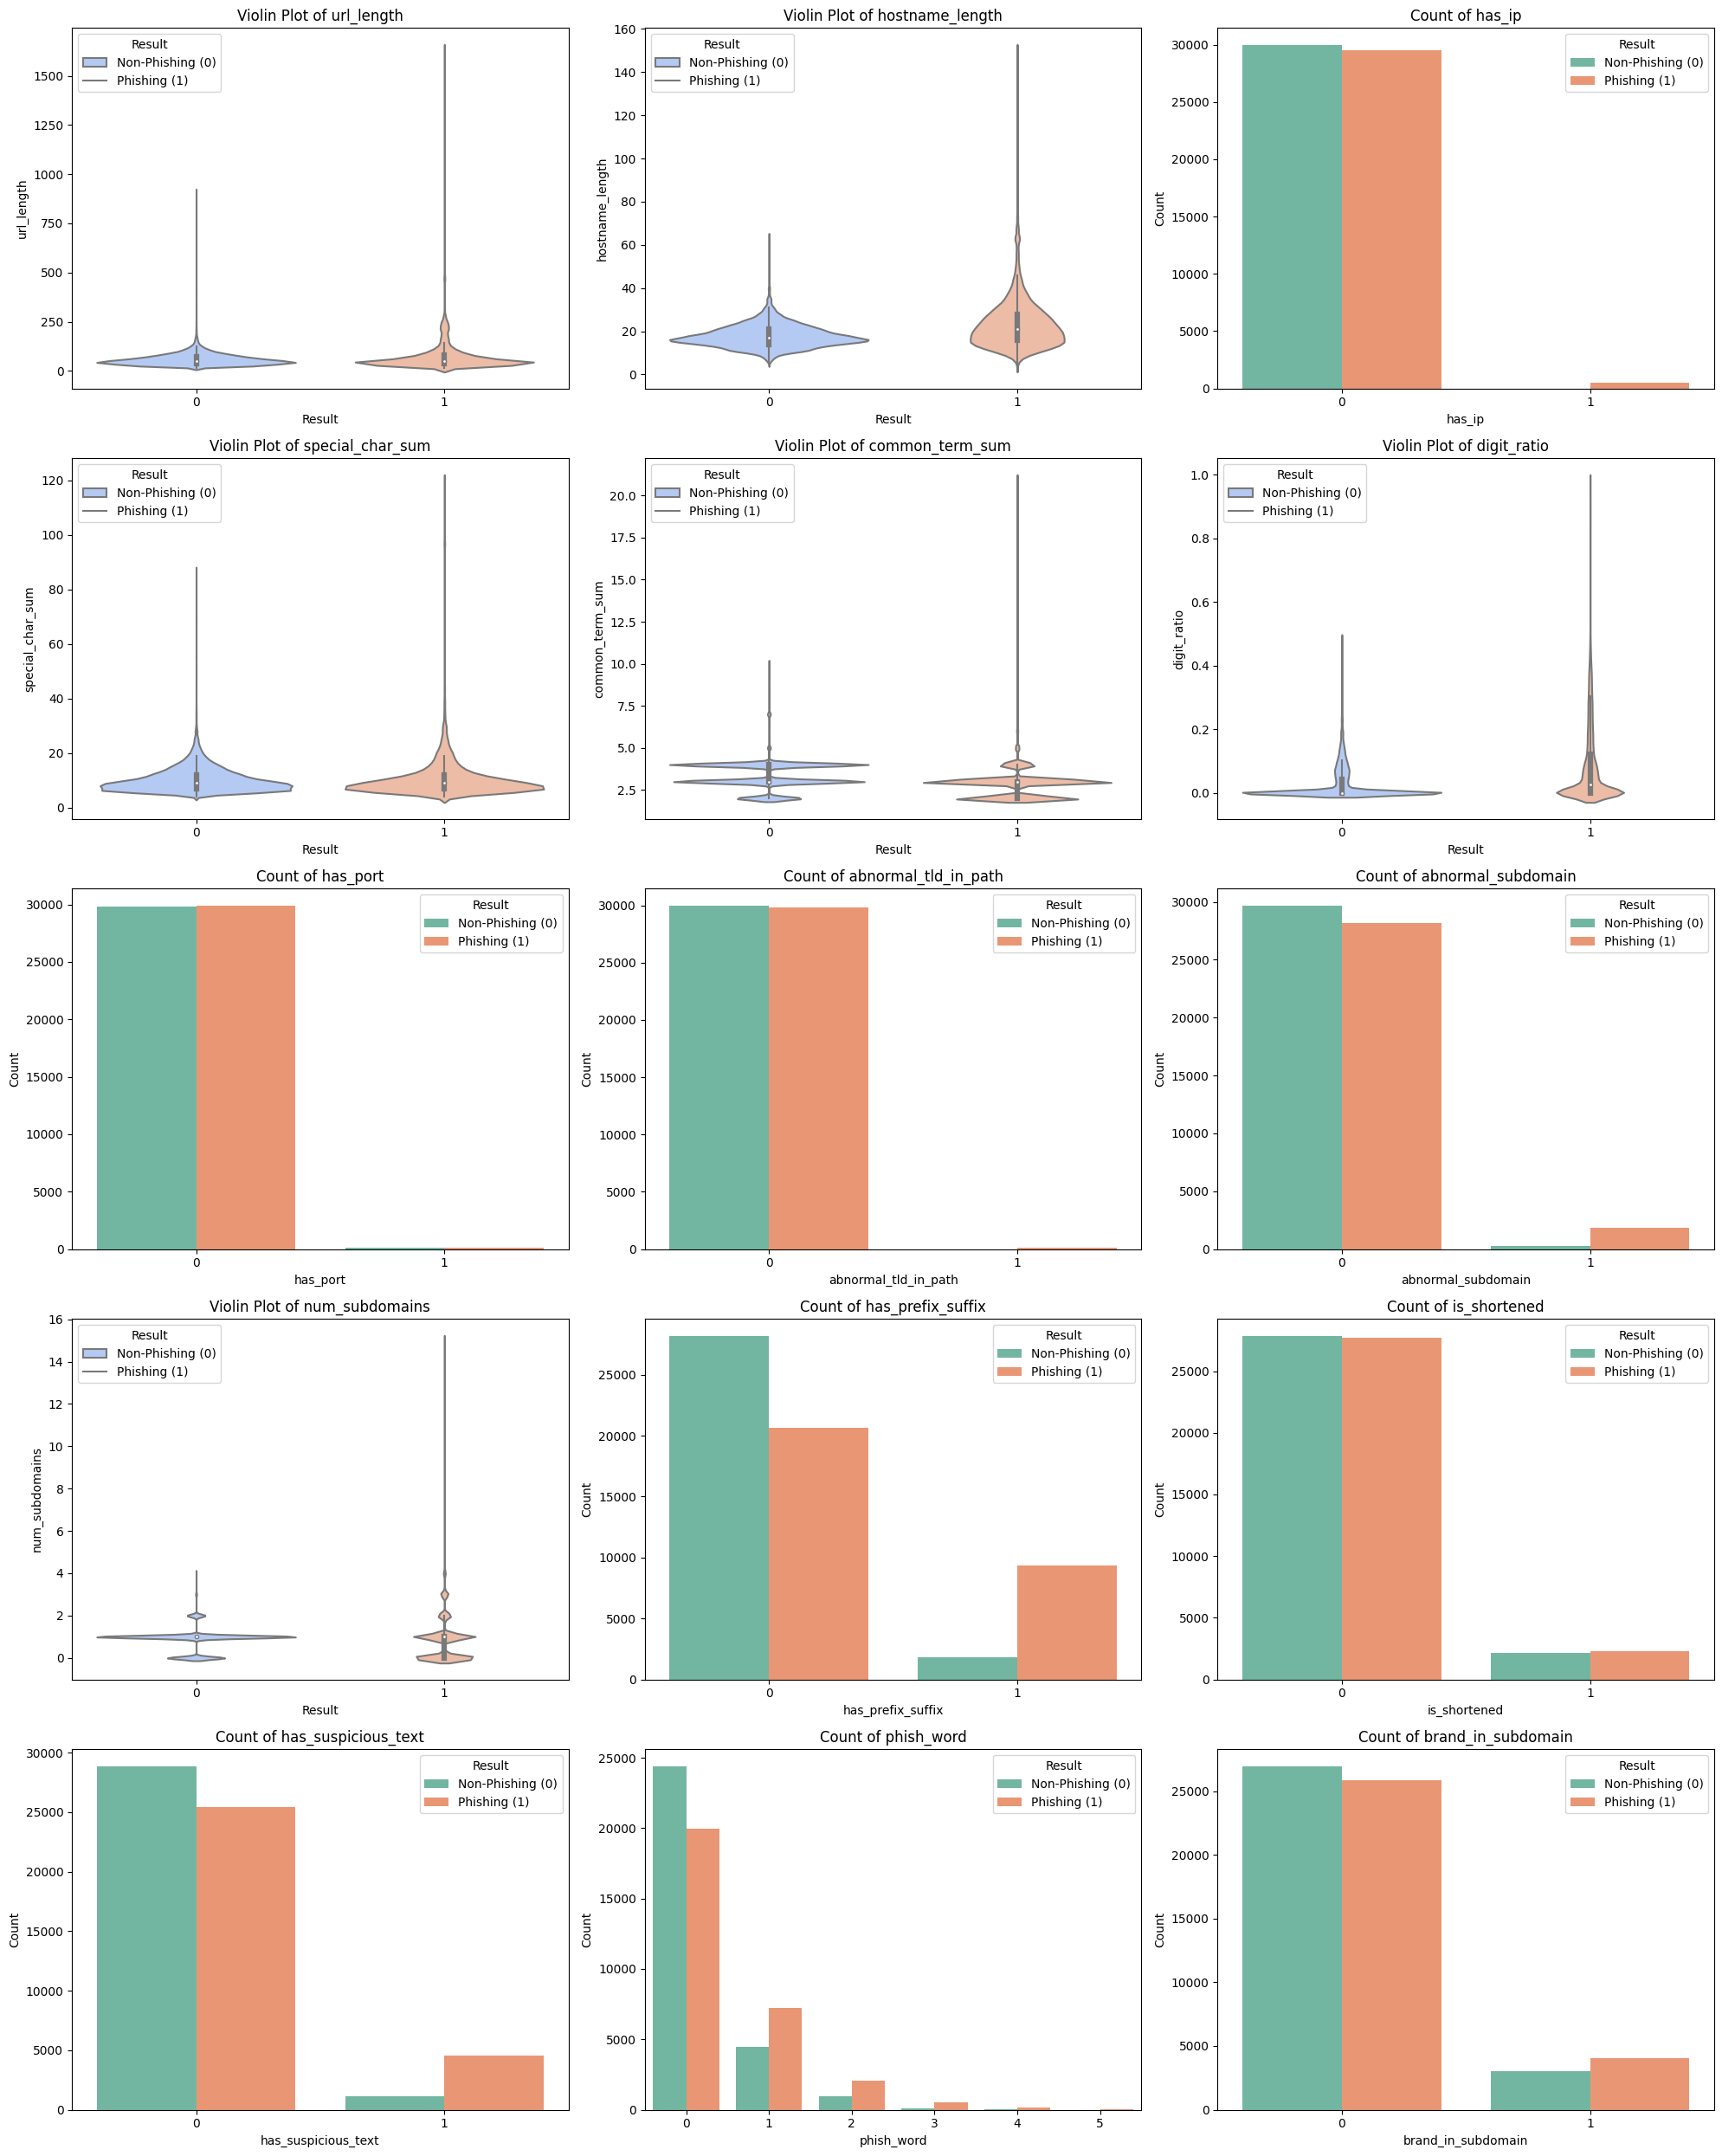

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 시각화를 위한 그리드 생성
num_features = len(features)
cols = 3
rows = (num_features + cols - 1) // cols  # 필요한 행 계산
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

# 각 변수 특성에 따른 시각화
for i, feature in enumerate(features):
    unique_vals = url[feature].nunique()
    dtype = url[feature].dtype
    
    # 범주형 변수: 고유값이 적은 경우 countplot 사용
    if unique_vals <= 10 and dtype in ['int64', 'object']:
        sns.countplot(
            data=url, 
            x=feature, 
            hue="result", 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Count of {feature}')
        axes[i].set_ylabel('Count')
    
    # 수치형 변수: 값의 범위가 넓은 경우 바이올린 플롯 사용
    elif dtype in ['float64', 'int64'] and unique_vals > 10:
        sns.violinplot(
            data=url, 
            x="result", 
            y=feature, 
            palette="coolwarm", 
            ax=axes[i]
        )
        axes[i].set_title(f'Violin Plot of {feature}')
        axes[i].set_xlabel('Result')
        axes[i].set_ylabel(feature)
    
    # 이진 변수: 고유값이 2개인 경우 막대 그래프 사용
    elif unique_vals == 2:
        sns.barplot(
            data=url, 
            x=feature, 
            y="result", 
            palette="Set2", 
            ax=axes[i],
            estimator=lambda x: np.mean(x) * 100  # 퍼센티지로 표시
        )
        axes[i].set_title(f'Percentage of {feature} by Result')
        axes[i].set_ylabel('Percentage')
    
    # 그 외: 히스토그램과 KDE 사용
    else:
        sns.histplot(
            data=url, 
            x=feature, 
            hue="result", 
            multiple="dodge", 
            kde=True, 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')
    
    axes[i].legend(title='Result', labels=['Non-Phishing (0)', 'Phishing (1)'])

# 사용되지 않은 서브플롯 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()


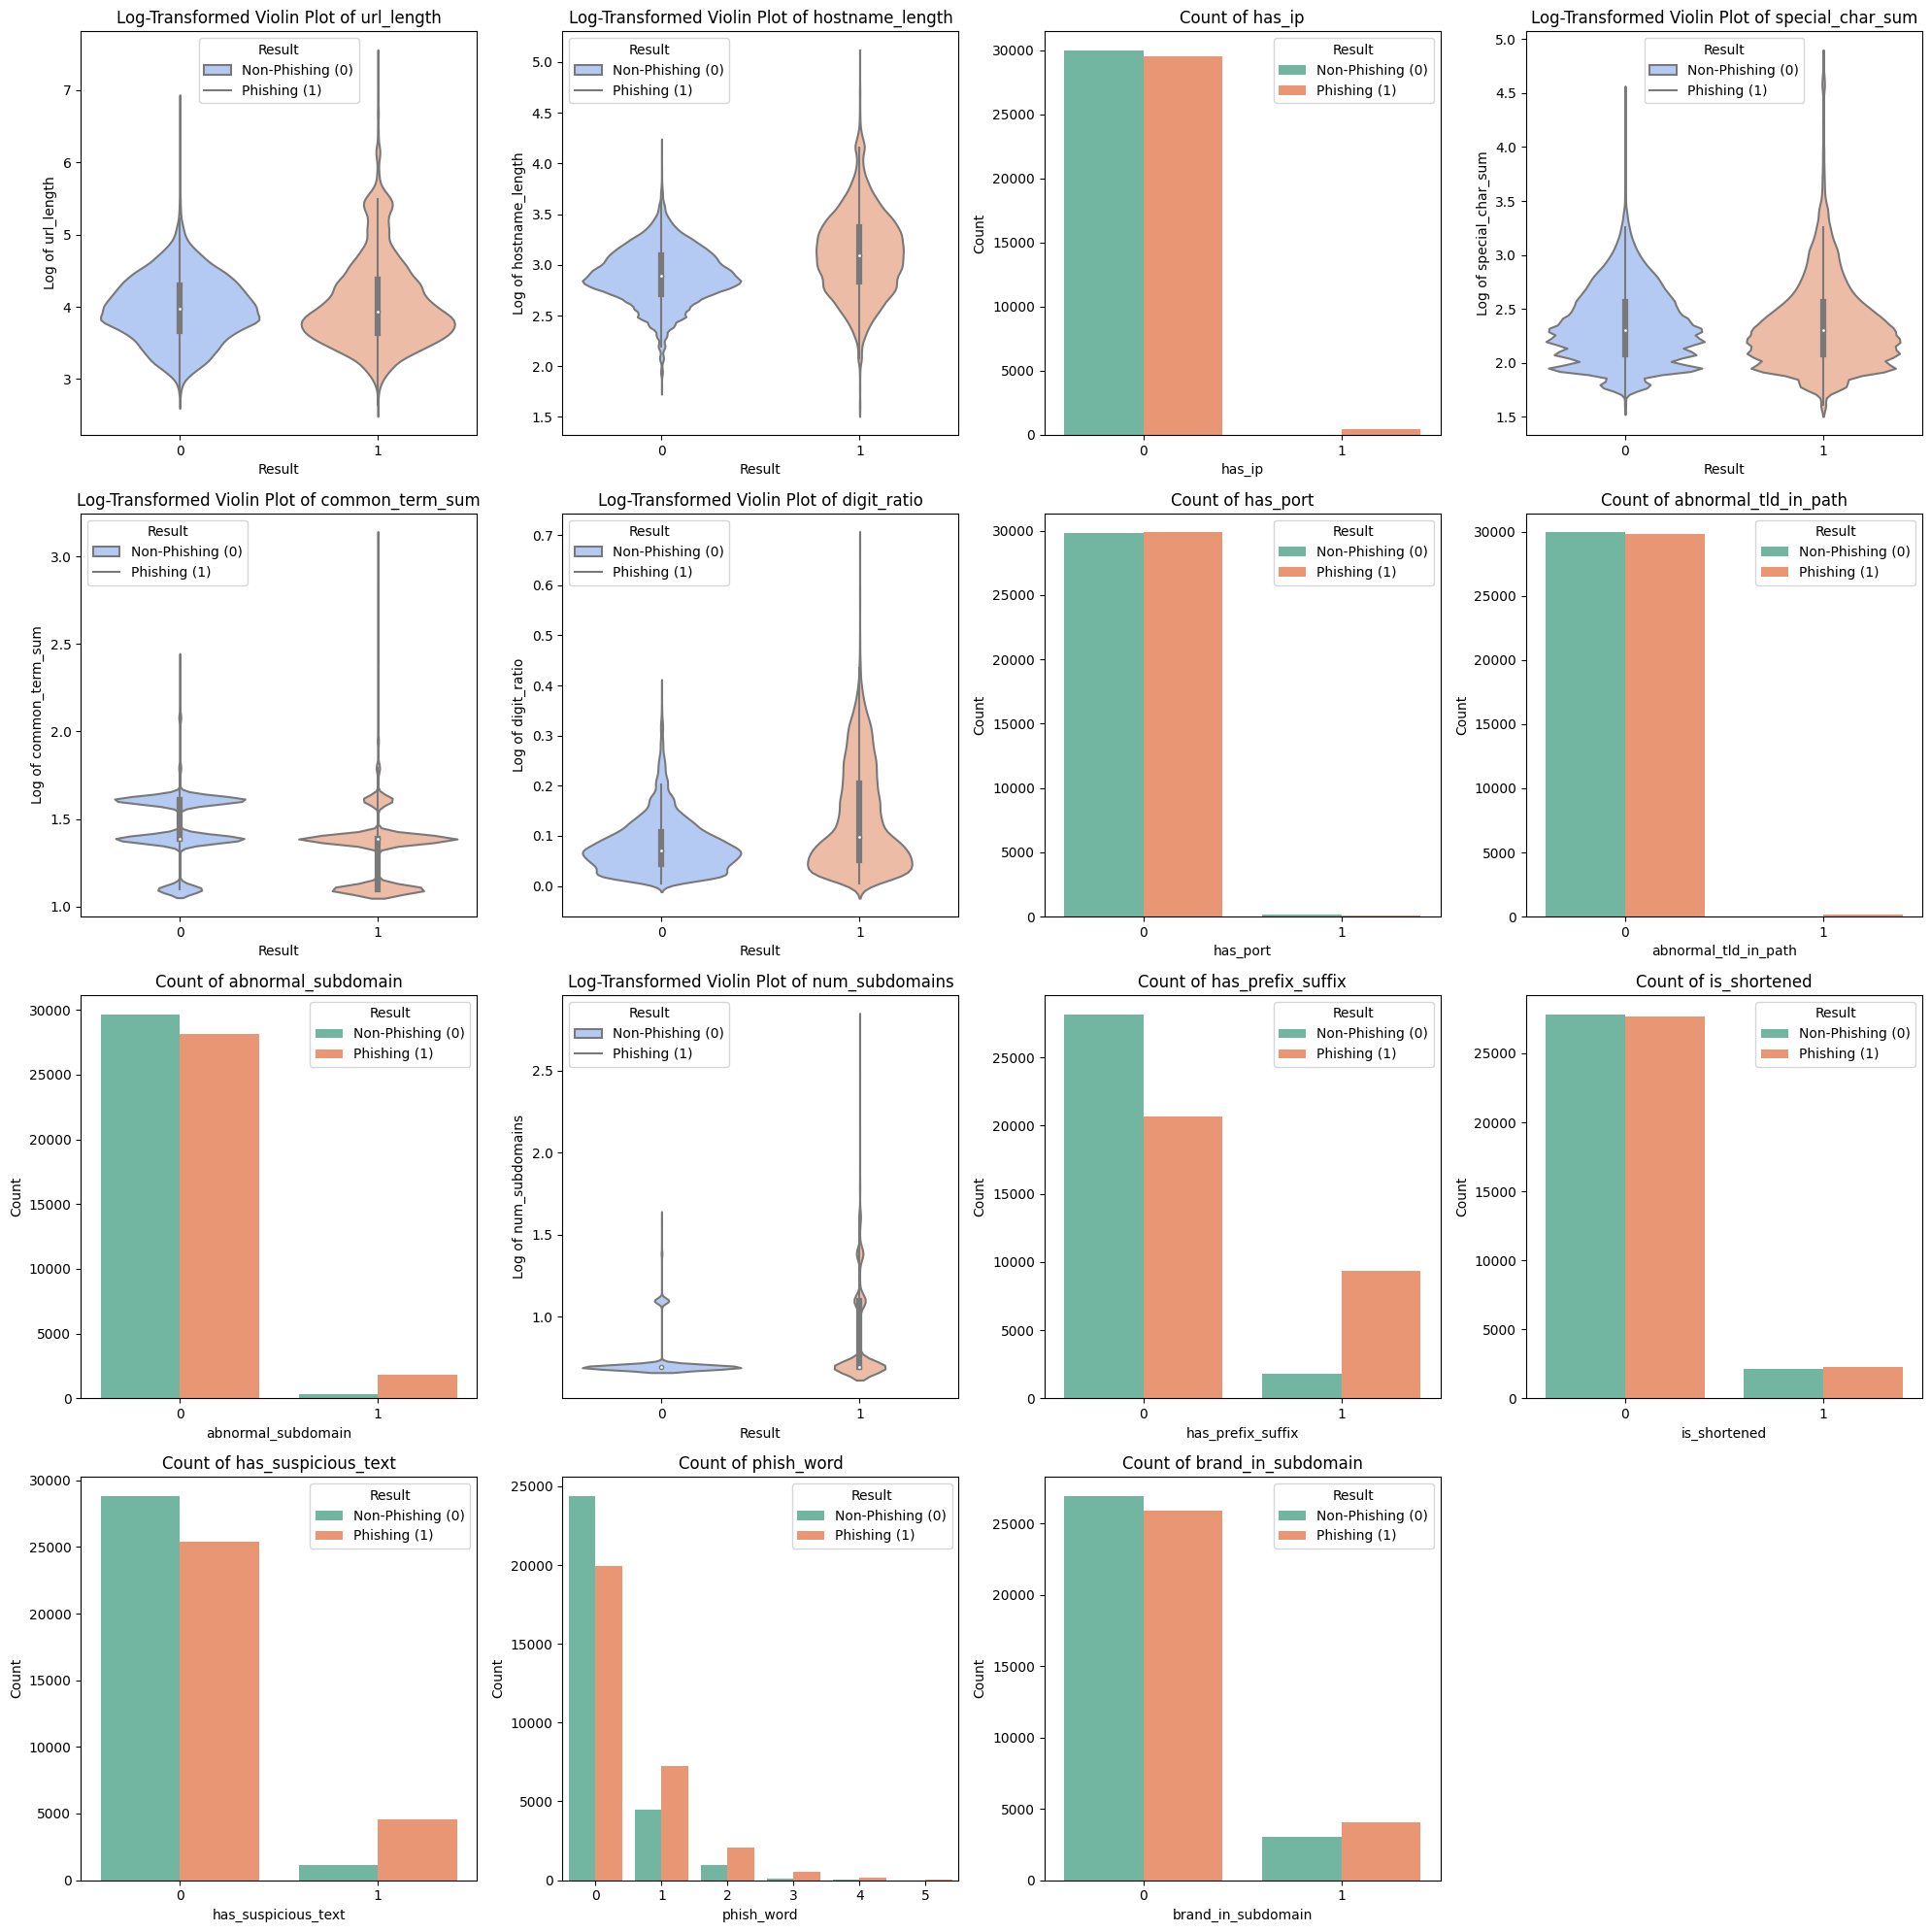

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 시각화를 위한 그리드 생성
num_features = len(features)
cols = 4
rows = (num_features + cols - 1) // cols  # 필요한 행 계산
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

# 각 변수 특성에 따른 시각화
for i, feature in enumerate(features):
    unique_vals = url[feature].nunique()
    dtype = url[feature].dtype
    
    # 범주형 변수: 고유값이 적은 경우 countplot 사용
    if unique_vals <= 10 and dtype in ['int64', 'object']:
        sns.countplot(
            data=url, 
            x=feature, 
            hue="result", 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Count of {feature}')
        axes[i].set_ylabel('Count')
    
    # 수치형 변수: 값의 범위가 넓은 경우 로그 변환 후 바이올린 플롯 사용
    elif dtype in ['float64', 'int64'] and unique_vals > 10:
        # 로그 변환 (0이 아닌 값만)
        transformed_data = url[url[feature] > 0].copy()
        transformed_data[feature] = np.log1p(transformed_data[feature])
        sns.violinplot(
            data=transformed_data, 
            x="result", 
            y=feature, 
            palette="coolwarm", 
            ax=axes[i]
        )
        axes[i].set_title(f'Log-Transformed Violin Plot of {feature}')
        axes[i].set_xlabel('Result')
        axes[i].set_ylabel(f'Log of {feature}')
    
    # 이진 변수: 고유값이 2개인 경우 pointplot 사용하여 퍼센티지 표시
    elif unique_vals == 2:
        sns.pointplot(
            data=url, 
            x=feature, 
            y="result", 
            palette="Set2", 
            ax=axes[i],
            estimator=lambda x: np.mean(x) * 100  # 퍼센티지로 표시
        )
        axes[i].set_title(f'Percentage of {feature} by Result')
        axes[i].set_ylabel('Percentage')
    
    # 그 외: 로그 변환 후 히스토그램과 KDE 사용
    else:
        # 로그 변환 (0이 아닌 값만)
        transformed_data = url[url[feature] > 0].copy()
        transformed_data[feature] = np.log1p(transformed_data[feature])
        sns.histplot(
            data=transformed_data, 
            x=feature, 
            hue="result", 
            multiple="dodge", 
            kde=True, 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Log-Transformed Distribution of {feature}')
        axes[i].set_xlabel(f'Log of {feature}')
        axes[i].set_ylabel('Count')
    
    axes[i].legend(title='Result', labels=['Non-Phishing (0)', 'Phishing (1)'])

# 사용되지 않은 서브플롯 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()


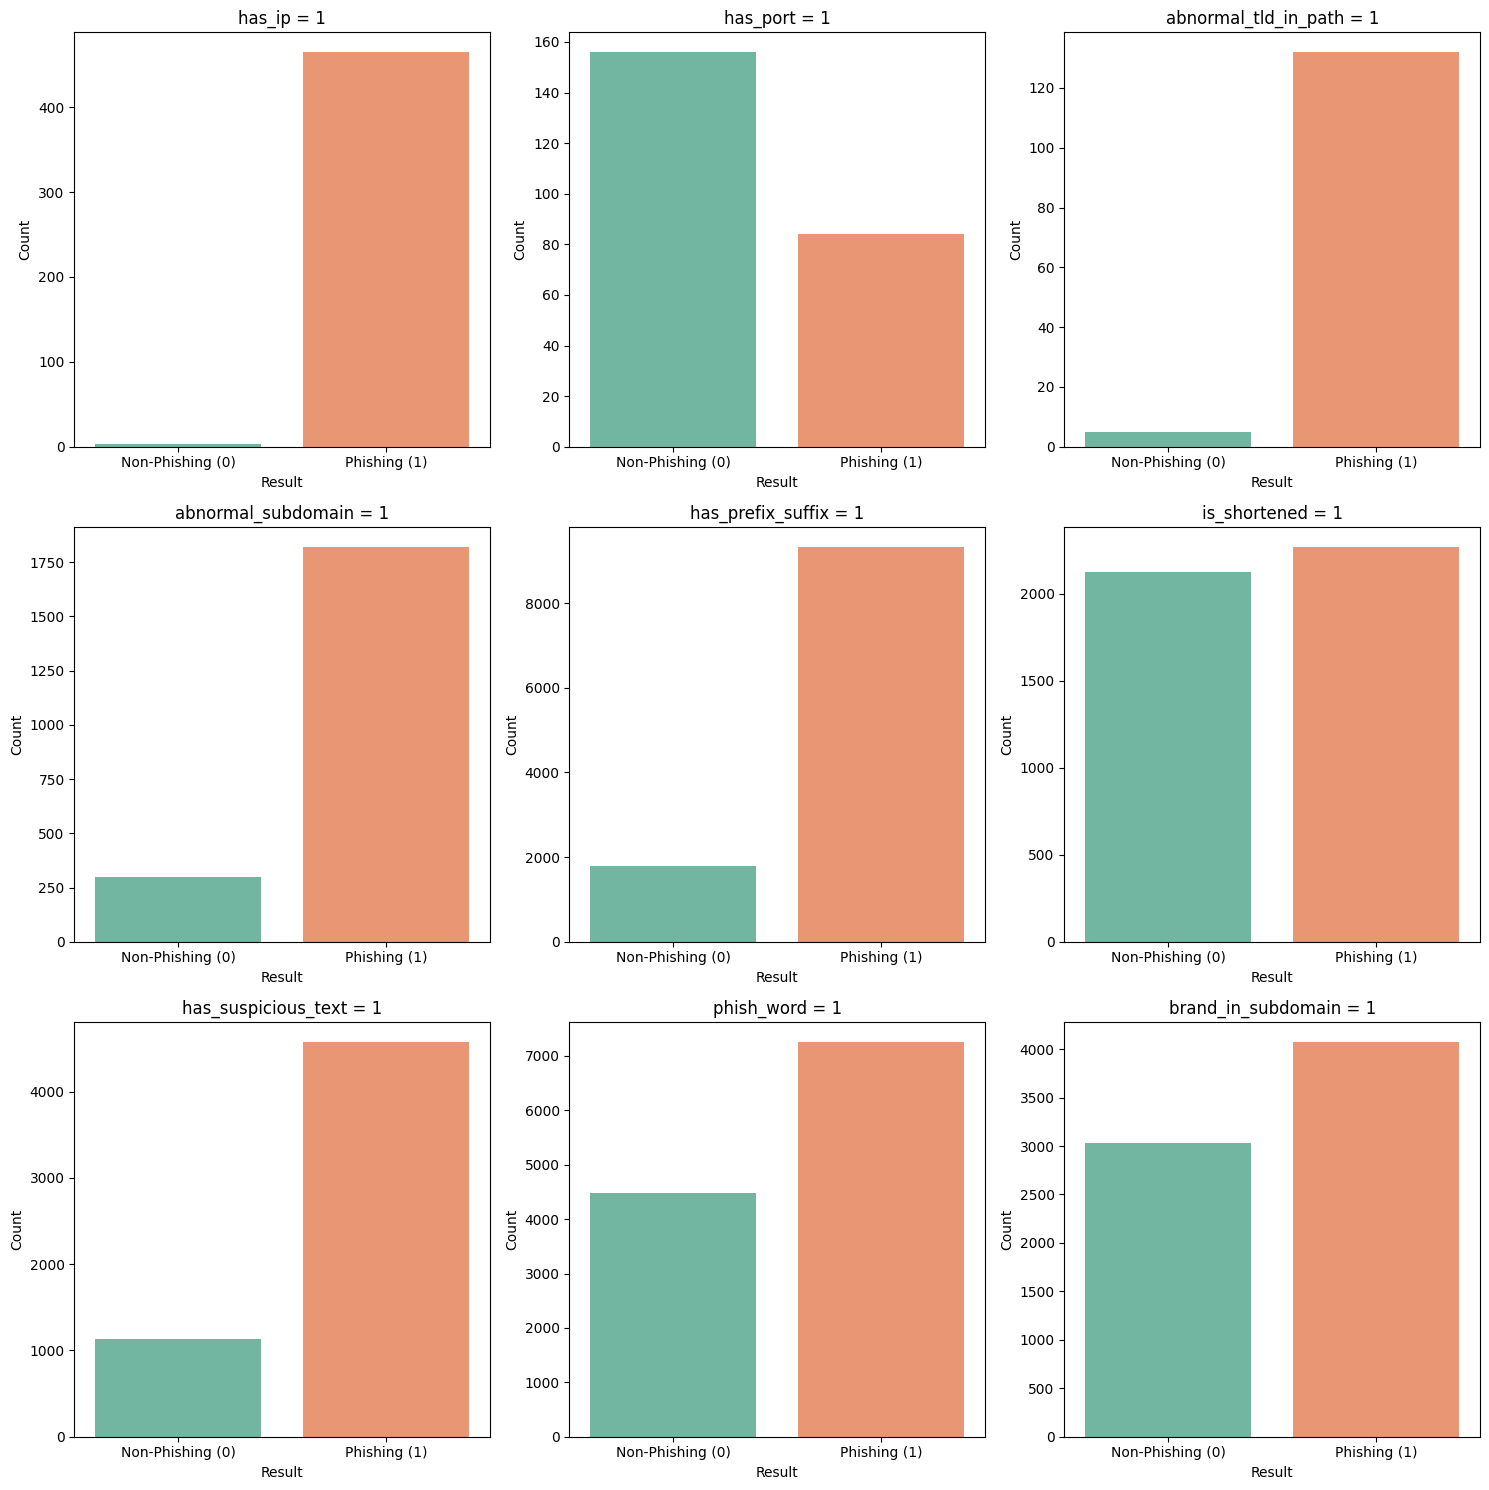

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

warnings.filterwarnings('ignore')

# 분석할 이진 변수 목록
binary_features = ['has_ip', 'has_port', 'abnormal_tld_in_path', 'abnormal_subdomain', 'has_prefix_suffix','is_shortened','has_suspicious_text','phish_word','brand_in_subdomain']

# 시각화를 위한 그리드 생성
num_features = len(binary_features)
cols = 3
rows = (num_features + cols - 1) // cols  # 필요한 행 계산
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

# 각 이진 변수에 대한 시각화
for i, feature in enumerate(binary_features):
    # 해당 변수의 값이 1인 데이터만 필터링
    filtered_data = url[url[feature] == 1]
    
    # result 값에 따른 개수 세기
    result_counts = filtered_data['result'].value_counts().sort_index()
    
    # 막대 그래프 그리기
    sns.barplot(
        x=result_counts.index,
        y=result_counts.values,
        palette='Set2',
        ax=axes[i]
    )
    axes[i].set_title(f'{feature} = 1')
    axes[i].set_xlabel('Result')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Non-Phishing (0)', 'Phishing (1)'])

# 사용되지 않은 서브플롯 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()


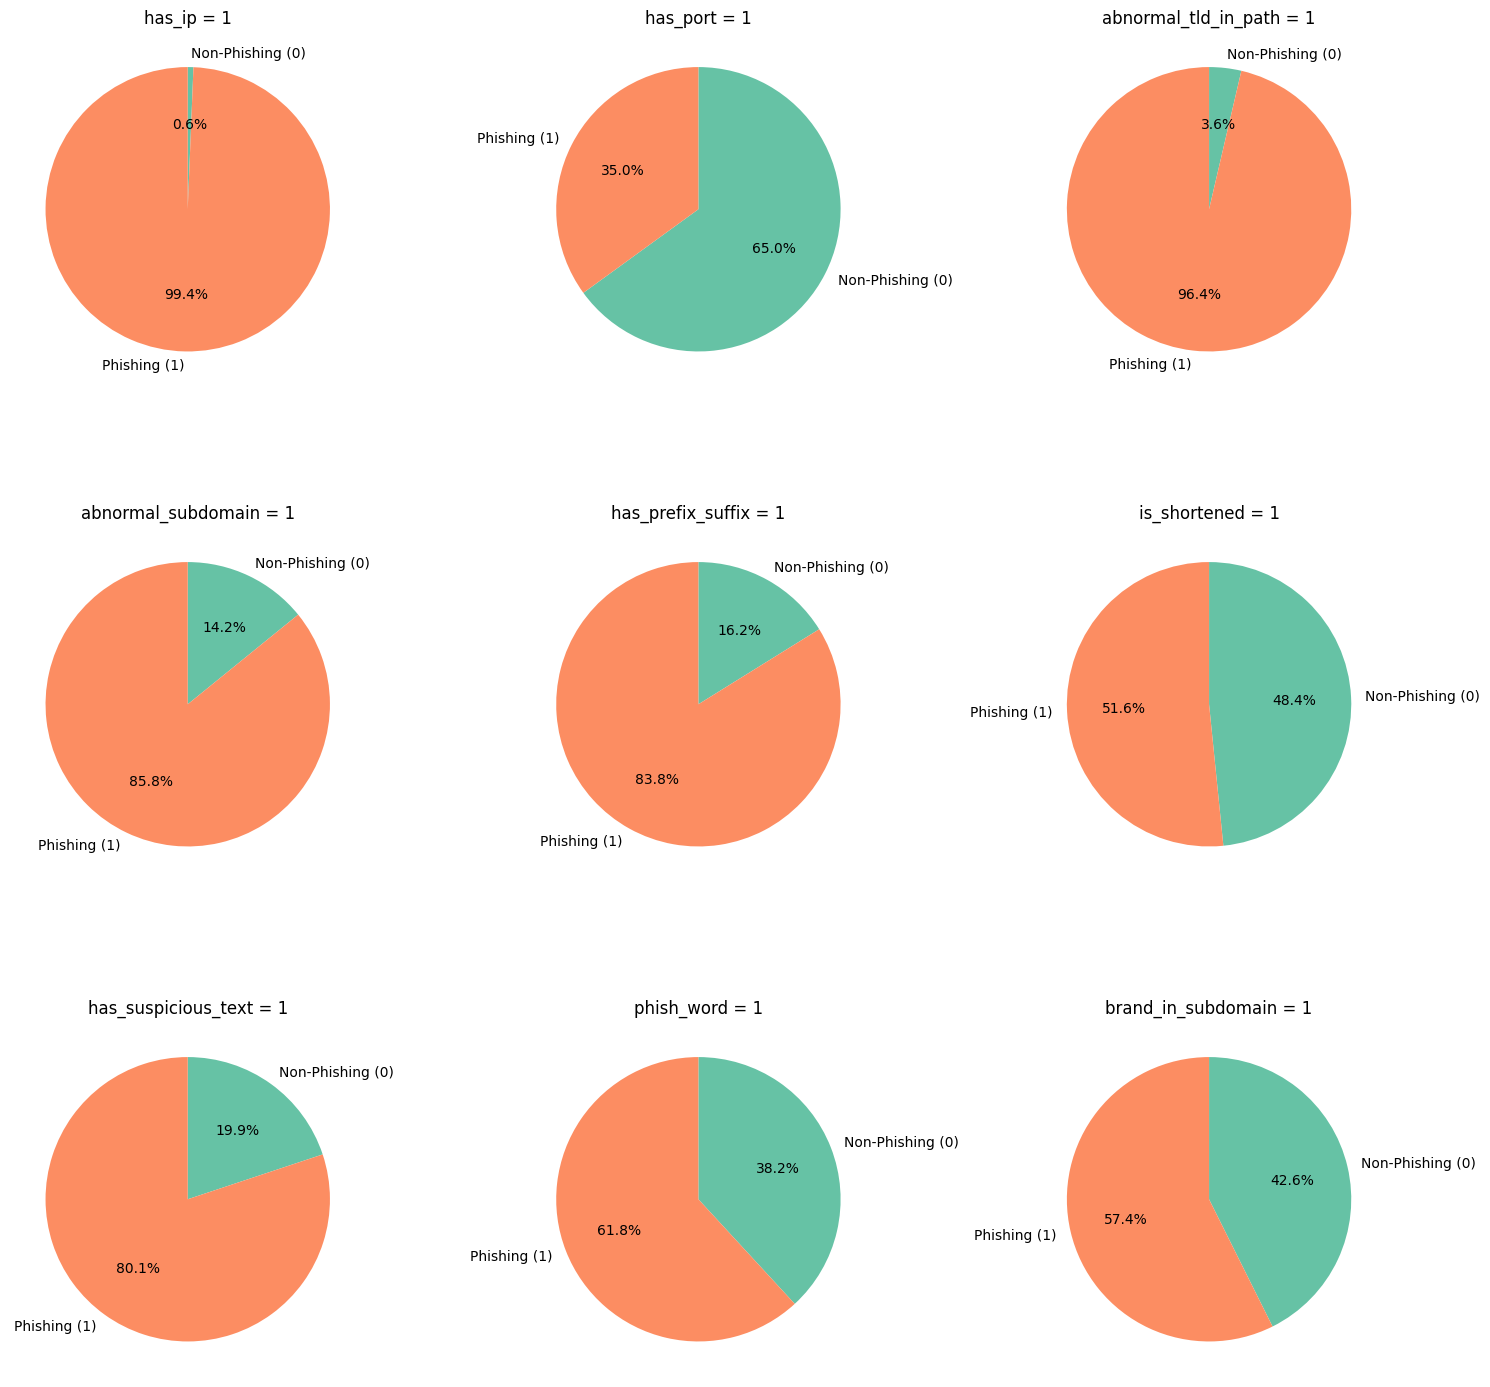

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# 분석할 이진 변수 목록
binary_features = [
    'has_ip', 'has_port', 'abnormal_tld_in_path',
    'abnormal_subdomain', 'has_prefix_suffix', 'is_shortened',
    'has_suspicious_text', 'phish_word', 'brand_in_subdomain'
]

# 시각화를 위한 그리드 생성
num_features = len(binary_features)
cols = 3
rows = (num_features + cols - 1) // cols  # 필요한 행 계산
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

# 각 이진 변수에 대한 시각화
for i, feature in enumerate(binary_features):
    # 해당 변수의 값이 1인 데이터만 필터링
    filtered_data = url[url[feature] == 1]
    
    # result 값에 따른 개수 세기
    result_counts = filtered_data['result'].value_counts().sort_index()
    
    # 파이 차트 그리기
    axes[i].pie(
        result_counts,
        labels=['Non-Phishing (0)', 'Phishing (1)'],
        autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62'],
        startangle=90,
        counterclock=False
    )
    axes[i].set_title(f'{feature} = 1')

# 사용되지 않은 서브플롯 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()


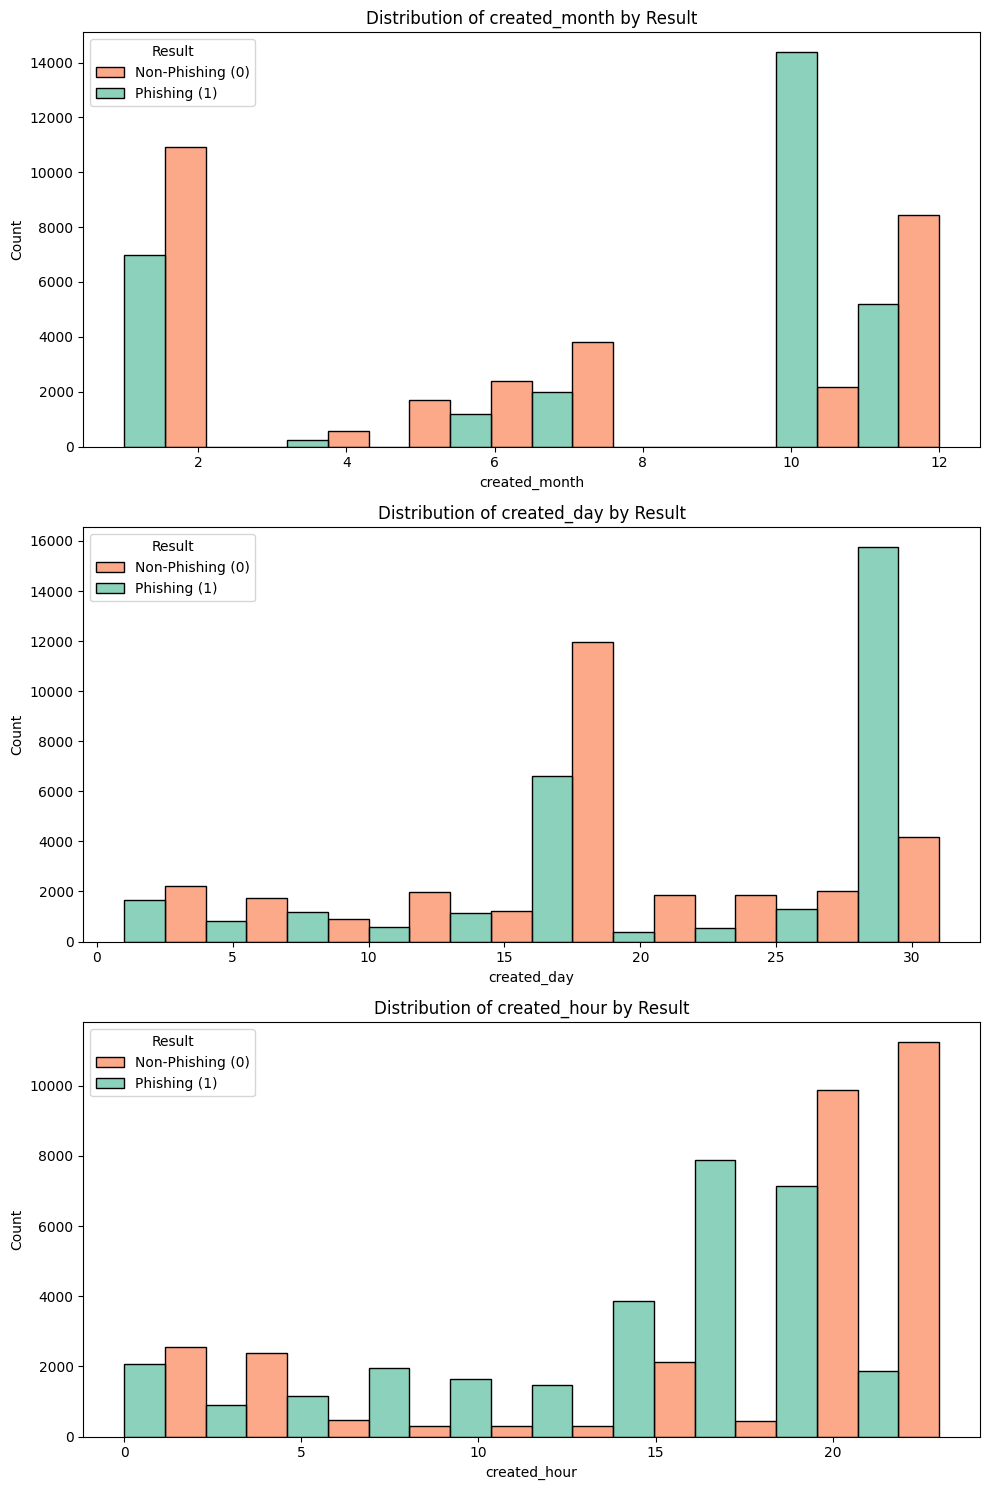

In [23]:
# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')

# 분석할 변수 목록
time_features = ['created_month', 'created_day', 'created_hour']

# 시각화를 위한 그리드 생성
num_features = len(time_features)
cols = 1
rows = num_features  # 각 변수별로 한 행씩 할당
fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 5))
if num_features == 1:
    axes = [axes]  # axes를 리스트로 변환하여 일관성 유지

# 각 변수에 대한 히스토그램 시각화
for i, feature in enumerate(time_features):
    sns.histplot(
        data=url,
        x=feature,
        hue='result',
        multiple='dodge',
        palette='Set2',
        ax=axes[i],
        kde=False,
        bins=10
    )
    axes[i].set_title(f'Distribution of {feature} by Result')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Result', labels=['Non-Phishing (0)', 'Phishing (1)'])

# 레이아웃 조정
plt.tight_layout()
plt.show()

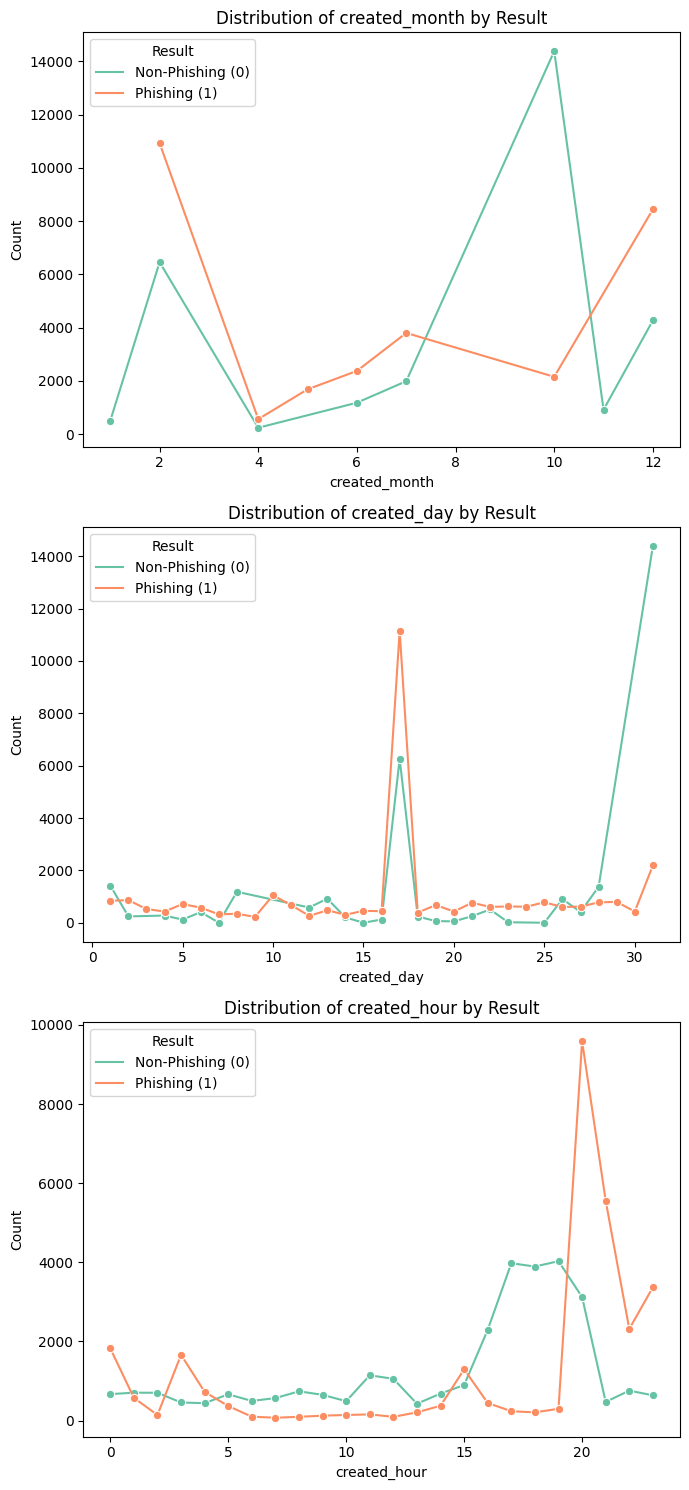

In [24]:
# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')

# 분석할 변수 목록
time_features = ['created_month', 'created_day', 'created_hour']

# 시각화를 위한 그리드 생성
num_features = len(time_features)
cols = 1
rows = num_features  # 각 변수별로 한 행씩 할당
fig, axes = plt.subplots(rows, cols, figsize=(7, rows * 5))
if num_features == 1:
    axes = [axes]  # axes를 리스트로 변환하여 일관성 유지

# 색상 팔레트와 라벨 매핑
palette = sns.color_palette('Set2')
label_colors = {0: palette[0], 1: palette[1]}  # Non-Phishing (0): 첫 번째 색상, Phishing (1): 두 번째 색상

# 각 변수에 대한 선그래프 시각화
for i, feature in enumerate(time_features):
    # 결과별로 그룹화하여 카운트 계산
    grouped = url.groupby([feature, 'result']).size().reset_index(name='count')
    
    sns.lineplot(
        data=grouped,
        x=feature,
        y='count',
        hue='result',
        palette='Set2',
        ax=axes[i],
        marker='o'
    )
    axes[i].set_title(f'Distribution of {feature} by Result')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
    # 범례 커스터마이징: 색상을 매핑하여 업데이트
    handles, labels = axes[i].get_legend_handles_labels()
    new_labels = [
        f'Non-Phishing (0)', 
        f'Phishing (1)'
    ]
    axes[i].legend(handles=handles, labels=new_labels, title='Result')

# 레이아웃 조정
plt.tight_layout()
plt.show()


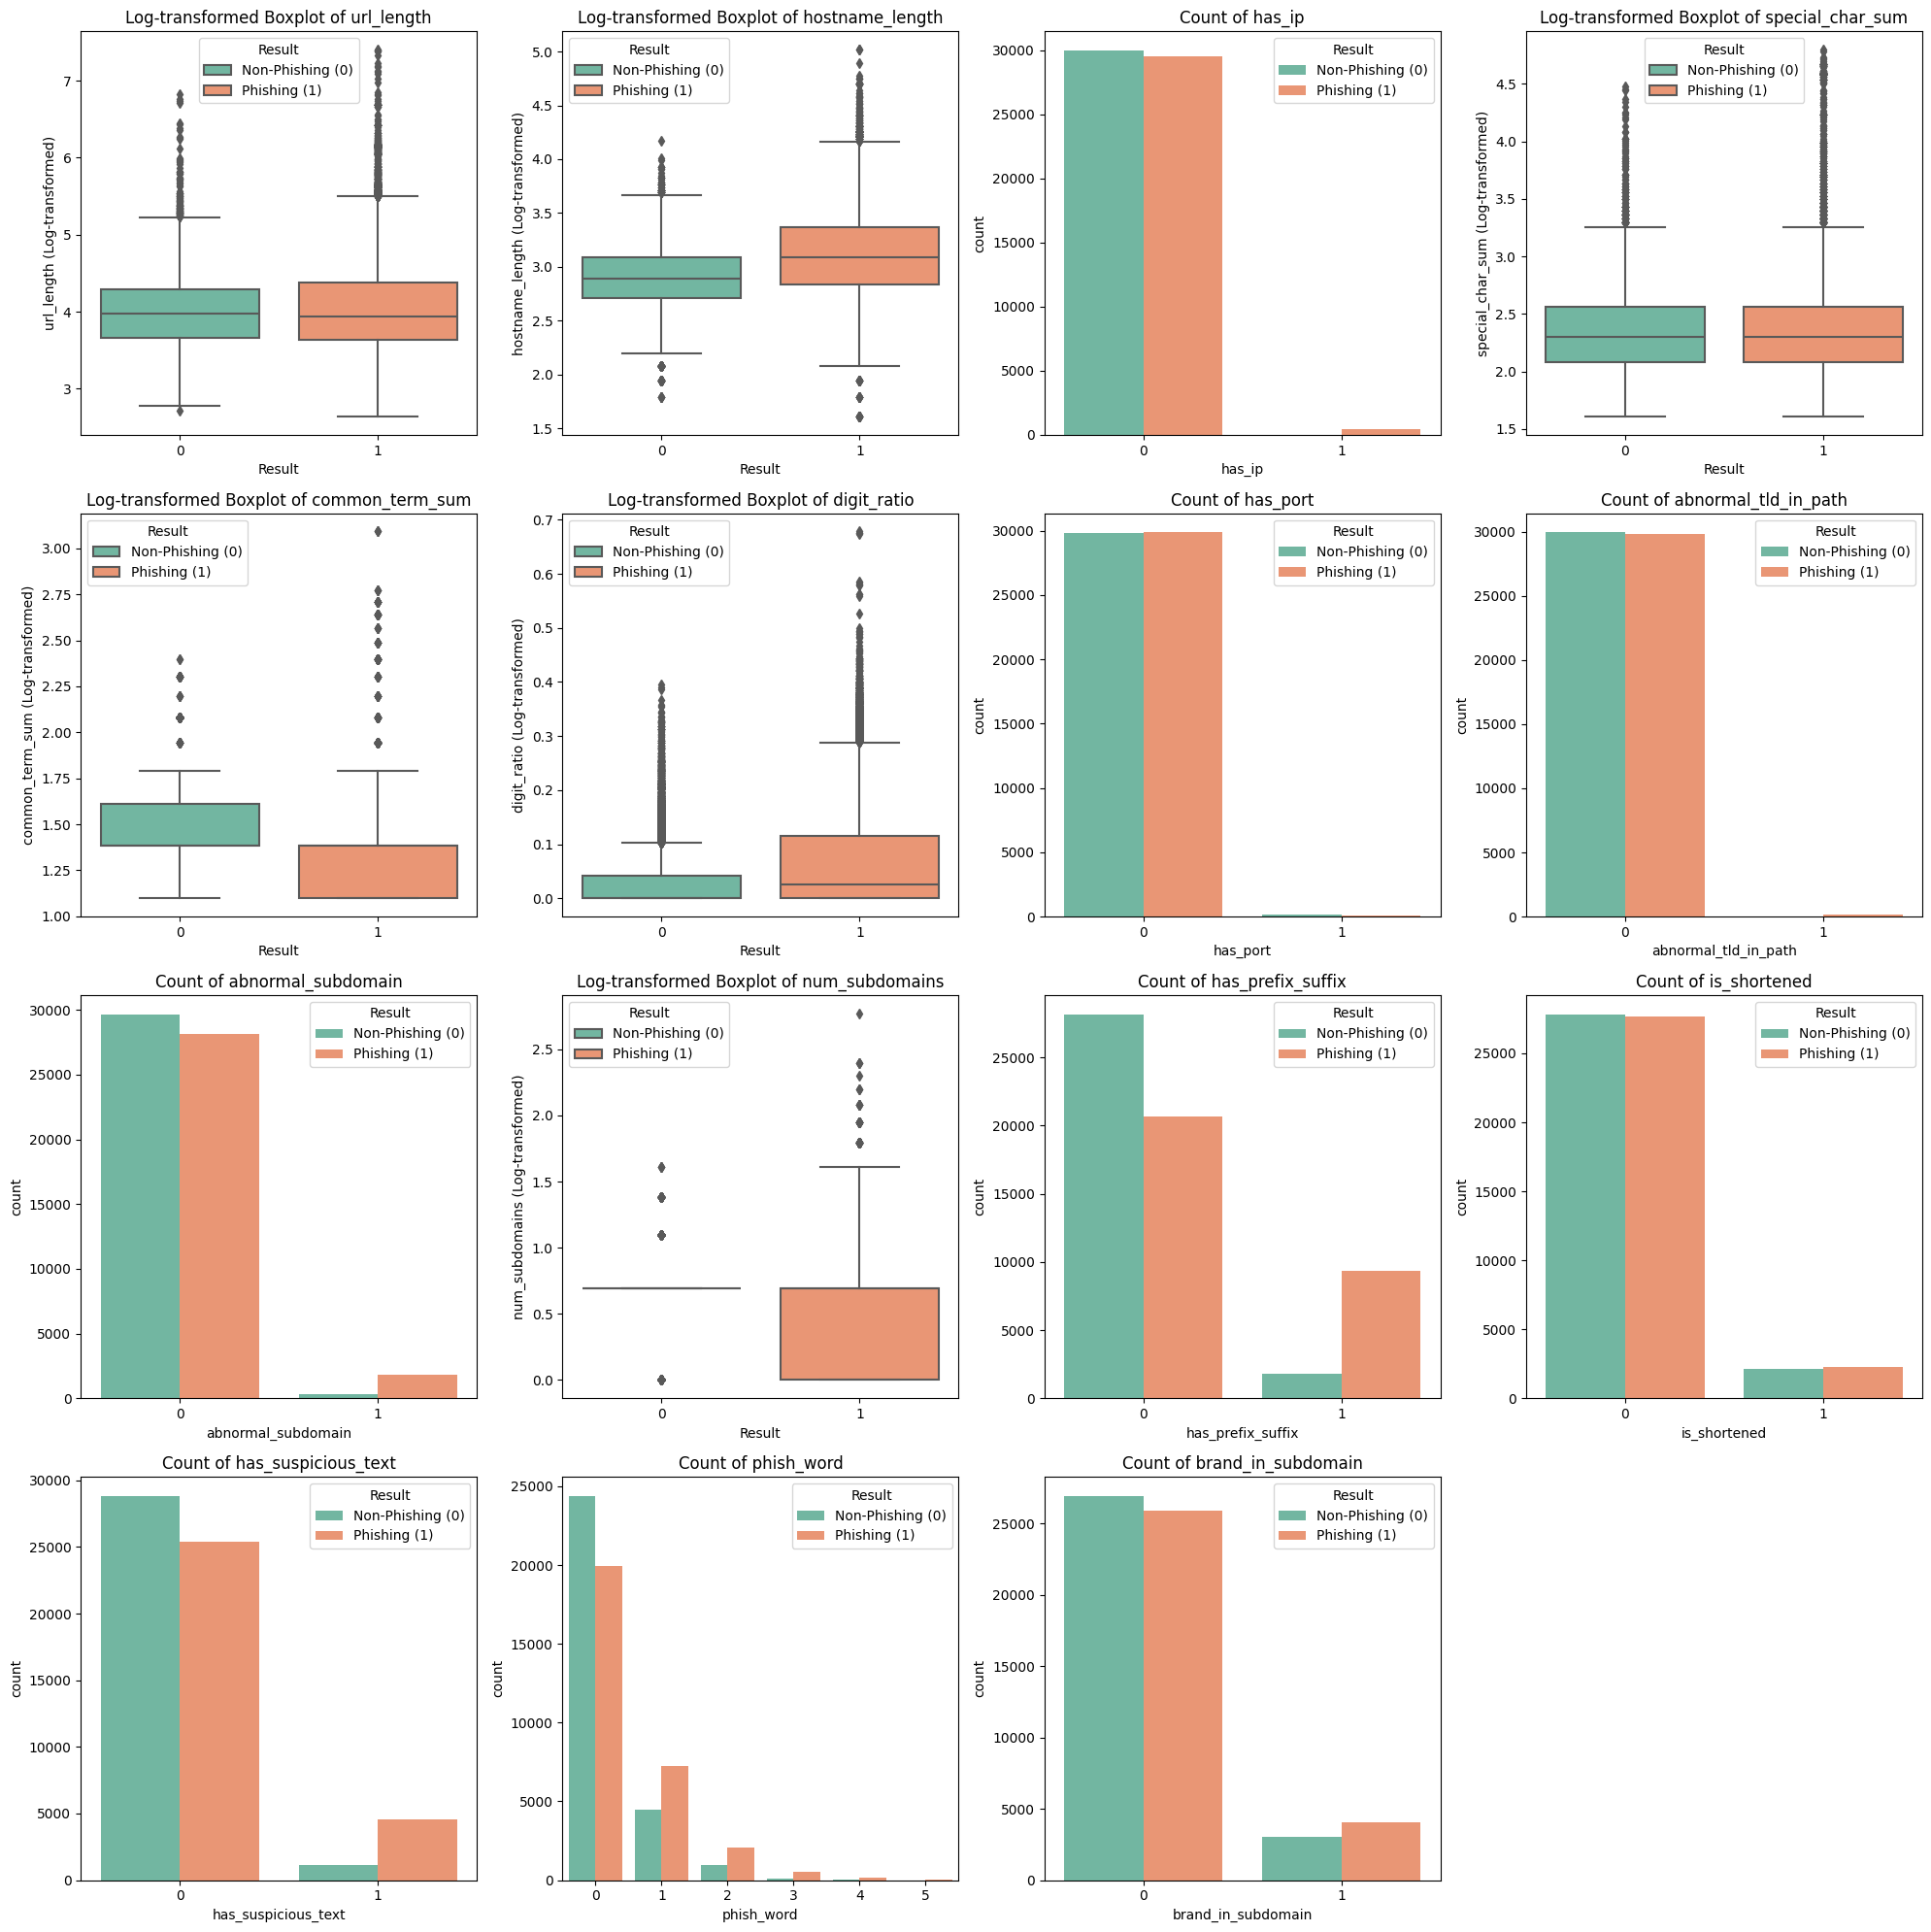

In [25]:
# 로그 변환 함수 정의 (0 또는 음수를 처리)
def safe_log_transform(series):
    return series.apply(lambda x: np.log(x + 1) if x > 0 else 0)

# 시각화를 위한 그리드 생성
num_features = len(features)
cols = 4
rows = (num_features + cols - 1) // cols  # 필요한 행 계산
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

# 각 변수 특성에 따른 시각화
for i, feature in enumerate(features):
    if url[feature].nunique() <= 10:  # 고유값이 적은 경우 countplot 사용
        sns.countplot(
            data=url, 
            x=feature, 
            hue="result", 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Count of {feature}')
    elif url[feature].dtype == 'float64' or url[feature].dtype == 'int64':  # 수치형 변수는 로그 변환 후 boxplot 사용
        # 로그 변환
        url[f'{feature}_log'] = safe_log_transform(url[feature])
        
        sns.boxplot(
            data=url, 
            x="result", 
            y=f'{feature}_log', 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Log-transformed Boxplot of {feature}')
        axes[i].set_xlabel('Result')
        axes[i].set_ylabel(f'{feature} (Log-transformed)')
    else:  # 기본적으로 histogram과 KDE 사용
        sns.histplot(
            data=url, 
            x=feature, 
            hue="result", 
            multiple="dodge", 
            kde=True, 
            palette="Set2", 
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {feature}')
    
    axes[i].legend(title='Result', labels=['Non-Phishing (0)', 'Phishing (1)'])

# 사용되지 않은 서브플롯 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()
